### Effect of the Visit Loss

In [1]:
import tensorflow as tf
import tools.mnist as mnist_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


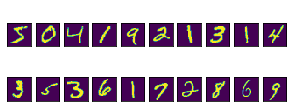

In [3]:
vis.imshow(train_images[:20], num_row=10, hspace=0, figsize=(5,2))

In [4]:
# labeled samples used per class
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
unsup_batch_size = 100


learning_rate = 1e-3
decay_steps = 5000
decay_factor = 0.33
visit_weight = 0.5

max_steps = 10000
eval_interval = 500

log_dir = "logs/visit-05"

seed = None

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

# gets sup_per_class samples for each class

# [10 (classes), 10 (samples), 28, 28, 1]

sup_by_label = semisup.sample_by_label(train_images, train_labels,
                        sup_per_class, NUM_LABELS, seed)

In [5]:
from ipywidgets import IntProgress, Layout

graph = tf.Graph()


with graph.as_default():
    
    model = semisup.SemisupModel(arch.mnist_model, NUM_LABELS, IMAGE_SHAPE)
    
    # iterator = up.create_input(train_images, train_labels, unsup_batch_size)
    # t_unsup_images, _ = up.create_input(train_images, train_labels, unsup_batch_size)
    
    #it = up.create_input(train_images, train_labels, unsup_batch_size)
    #t_unsup_images,_ = it.get_next()
    
    unsup_data = up.create_input(train_images, train_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    
    sup_data = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    sup_it   = sup_data.make_one_shot_iterator()
    
    item       = sup_it.get_next()
    temp_unzip = (list(zip(*item)))
    t_sup_images, t_sup_labels = tf.concat(temp_unzip[0], 0), tf.concat(temp_unzip[1], 0)
    
    #t_sup_images, t_sup_labels = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=10000)

---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/fully_c

In [6]:
from IPython.display import display

f = IntProgress(min=0, max=max_steps, layout= Layout(width="90%")) # instantiate the bar
display(f) # display the bar

with tf.Session(graph=graph) as sess:
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 1
    
    for step in range(max_steps):
        try:
            _, summaries = sess.run([train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            _, summaries = sess.run([train_op, summary_op])
            
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step + 1) % eval_interval == 0 or step == 99:
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print("saving model")
            saver.save(sess, log_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='90%'), max=10000)

Step: 99
[[ 965    0    0    0    4    5    3    1    0    2]
 [   0 1110    4    3    2    0    4    1   10    1]
 [  12    1  959    6   12    0    1   12   25    4]
 [   6    1    9  949    1   24    1    4   11    4]
 [   3    0    0    0  925    0    2    0    2   50]
 [   4    4    0    8    3  861    6    2    2    2]
 [  15    4    0    0    5   14  915    0    4    1]
 [   5   13   22   13    8    1    0  905    5   56]
 [   4    2    2    7    6    9   10    7  921    6]
 [   6    4    1    2   13   13    1   11    8  950]]
Test error: 5.40 %

saving model
Step: 499
[[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1125    5    0    0    0    4    0    1    0]
 [  10    2 1003    3    1    0    0    9    4    0]
 [   0    0    6  981    2    9    0    5    6    1]
 [   1    0    1    0  968    0    5    0    0    7]
 [   2    0    0    4    1  879    5    1    0    0]
 [   8    3    0    0    1    1  943    0    2    0]
 [   2   14   12    3    4    1    0  983    2

In [13]:
train_step = 10000
model_checkpoint = f"{log_dir}-{train_step}"

with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    embedded_unsup = sess.run(t_unsup_emb)

INFO:tensorflow:Restoring parameters from logs/visit-05-10000


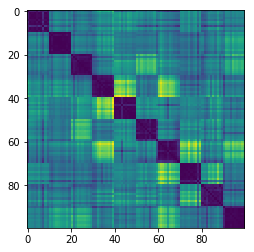

In [14]:
import tools.analyzer as ana
from tools.analyzer import Distance

similarity = ana.get_pairwise_distance(
    embedded_sup, 
    Distance.l2
)
import matplotlib.pyplot as plt
plt.imshow(similarity)

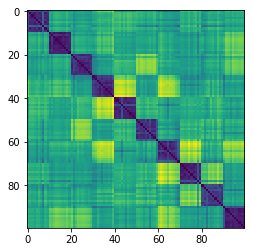

In [15]:
import tools.analyzer as ana
from tools.analyzer import Distance
similarity = ana.get_pairwise_distance(
    embedded_sup, 
    Distance.l1
)

plt.imshow(similarity)

INFO:tensorflow:Restoring parameters from logs/visit-05-100
INFO:tensorflow:Restoring parameters from logs/visit-05-1000
INFO:tensorflow:Restoring parameters from logs/visit-05-5000
INFO:tensorflow:Restoring parameters from logs/visit-05-10000


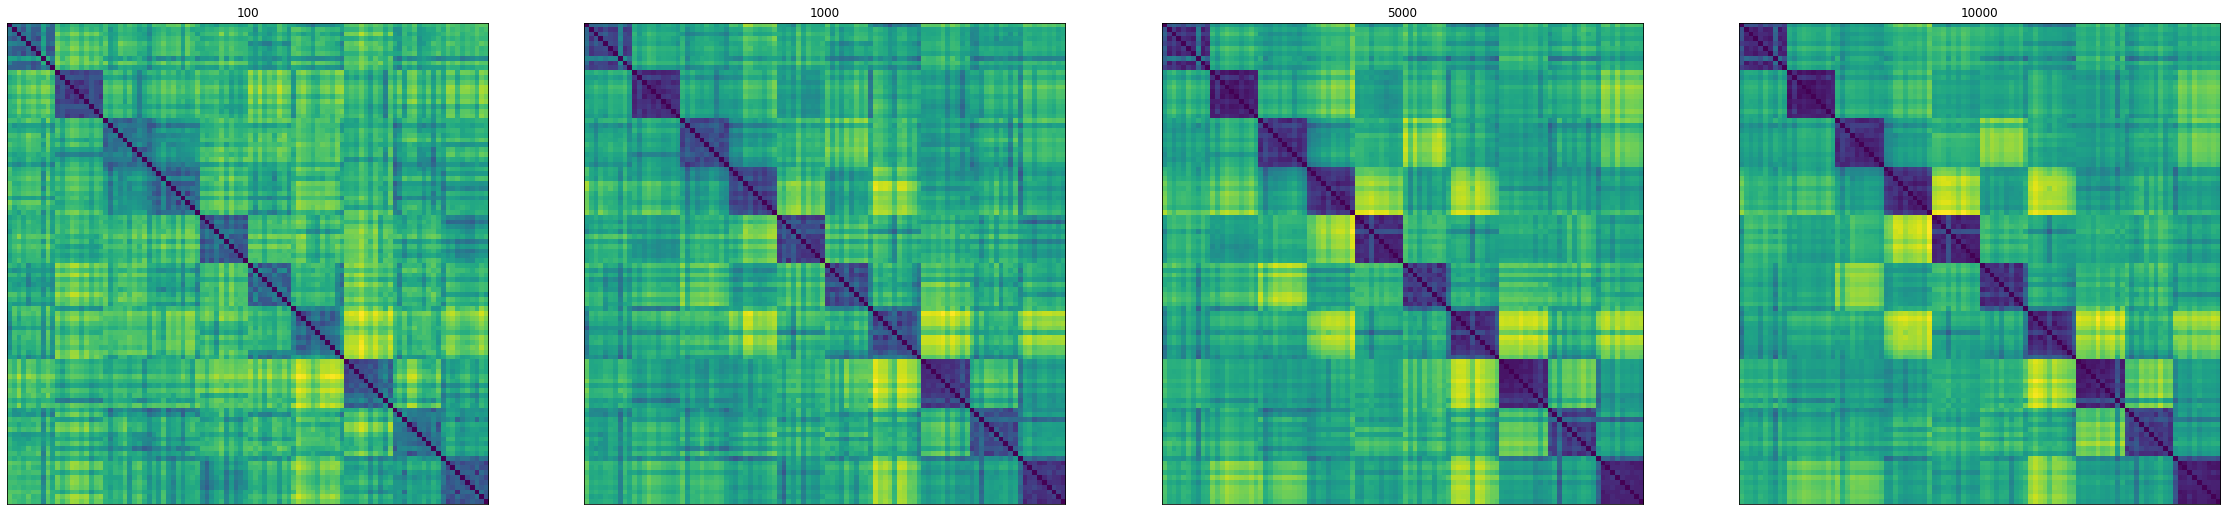

In [16]:
#f"{log_dir}-{train_step}"

def get_similarity(train_step, model_checkpoint, dist_func):
    
    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint + "-"+ str(train_step))
        
        sess.run(unsup_it.initializer)
        labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
        embedded_unsup = sess.run(t_unsup_emb)
        
    similarity = ana.get_pairwise_distance(
        embedded_sup, 
        dist_func
    )
    return similarity
    
dist_func = Distance.l1
similarities = []
labels = []
similarities.append(get_similarity(100, log_dir, dist_func))
labels.append(100)
similarities.append(get_similarity(1000, log_dir, dist_func))
labels.append(1000)
similarities.append(get_similarity(5000, log_dir, dist_func))
labels.append(5000)
similarities.append(get_similarity(10000, log_dir, dist_func))
labels.append(10000)

vis.imshow(similarities, figsize=(50,50), labels=labels, imgwidth=100)

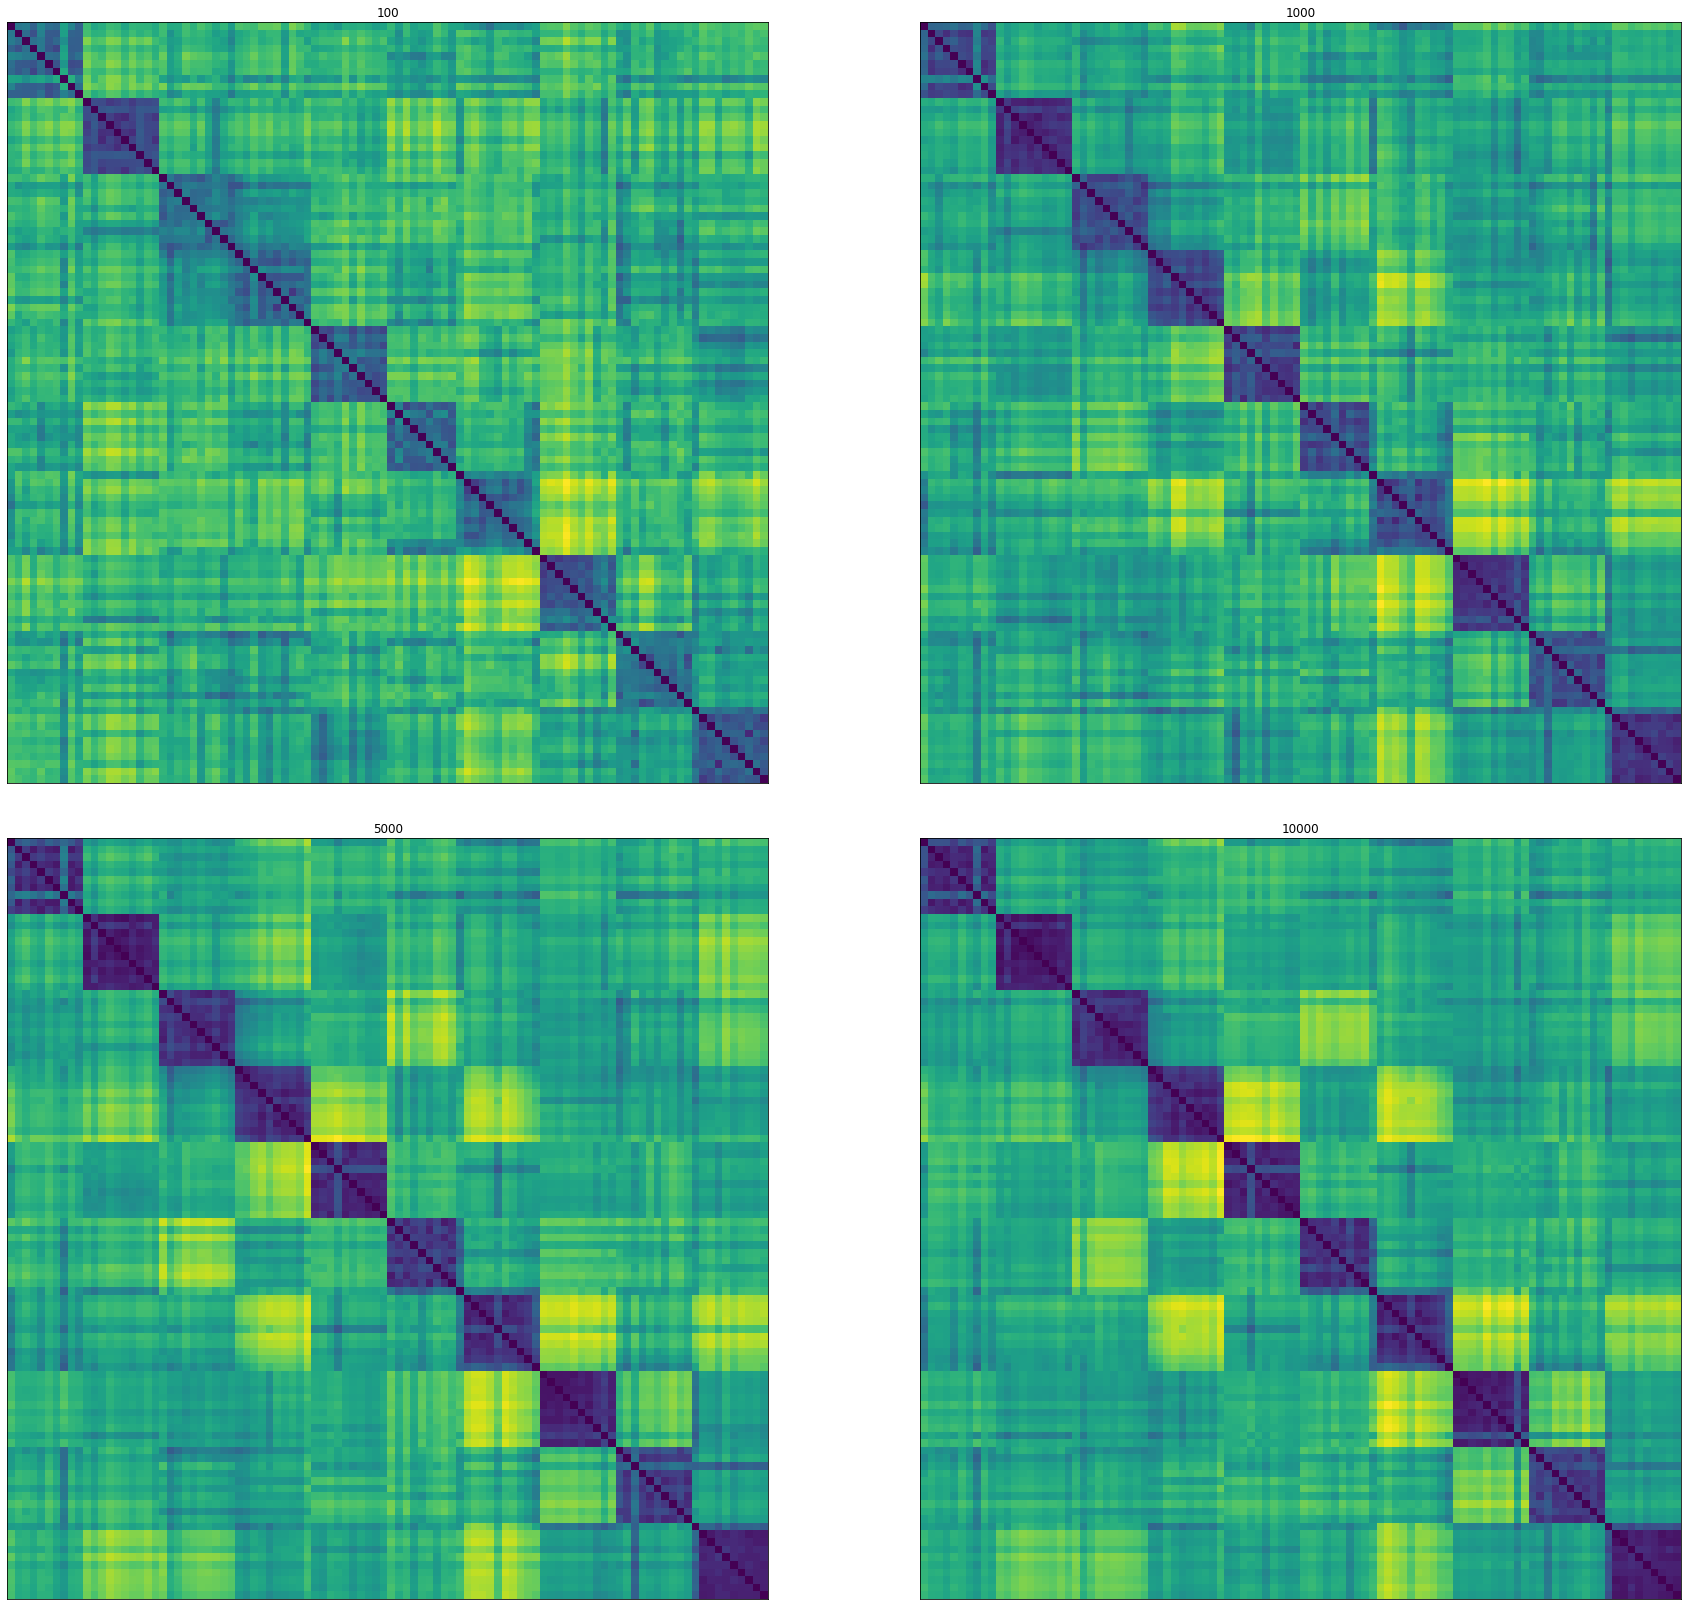

In [17]:
vis.imshow(similarities, figsize=(30,30), num_row=2,hspace=0, labels=labels, imgwidth=100)

In [18]:
def get_embedded(train_step, model_checkpoint):
    with tf.Session(graph=graph) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, log_dir+"-"+ str(train_step))
            
        sess.run(unsup_it.initializer)
        labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
        labels_unsup, embedded_unsup = sess.run([t_unsup_labels, t_unsup_emb])
        
        unsup = list(zip(labels_unsup, embedded_unsup))
        unsup.sort(key=lambda x: x[0])
        sorted_embedded_unsup = [pair[1] for pair in unsup]
    
    return np.vstack((embedded_sup, sorted_embedded_unsup))

def get_similarity(stacked, dist_func):
    
    similarity = ana.get_pairwise_distance(
        stacked, 
        dist_func
    )
    return similarity

def retrieve_similarity(train_step, model_checkpoint, dist_func):
    stacked = get_embedded(train_step, model_checkpoint)   
    return get_similarity(stacked, dist_func)
    
dist_func = Distance.k_dot
similarities = []
labels = []
similarities.append(retrieve_similarity(100, log_dir, dist_func))
labels.append(100)
similarities.append(retrieve_similarity(500, log_dir, dist_func))
labels.append(500)
similarities.append(retrieve_similarity(5000, log_dir, dist_func))
labels.append(5000)
similarities.append(retrieve_similarity(10000, log_dir, dist_func))
labels.append(10000)

INFO:tensorflow:Restoring parameters from logs/visit-05-100
INFO:tensorflow:Restoring parameters from logs/visit-05-500
INFO:tensorflow:Restoring parameters from logs/visit-05-5000
INFO:tensorflow:Restoring parameters from logs/visit-05-10000


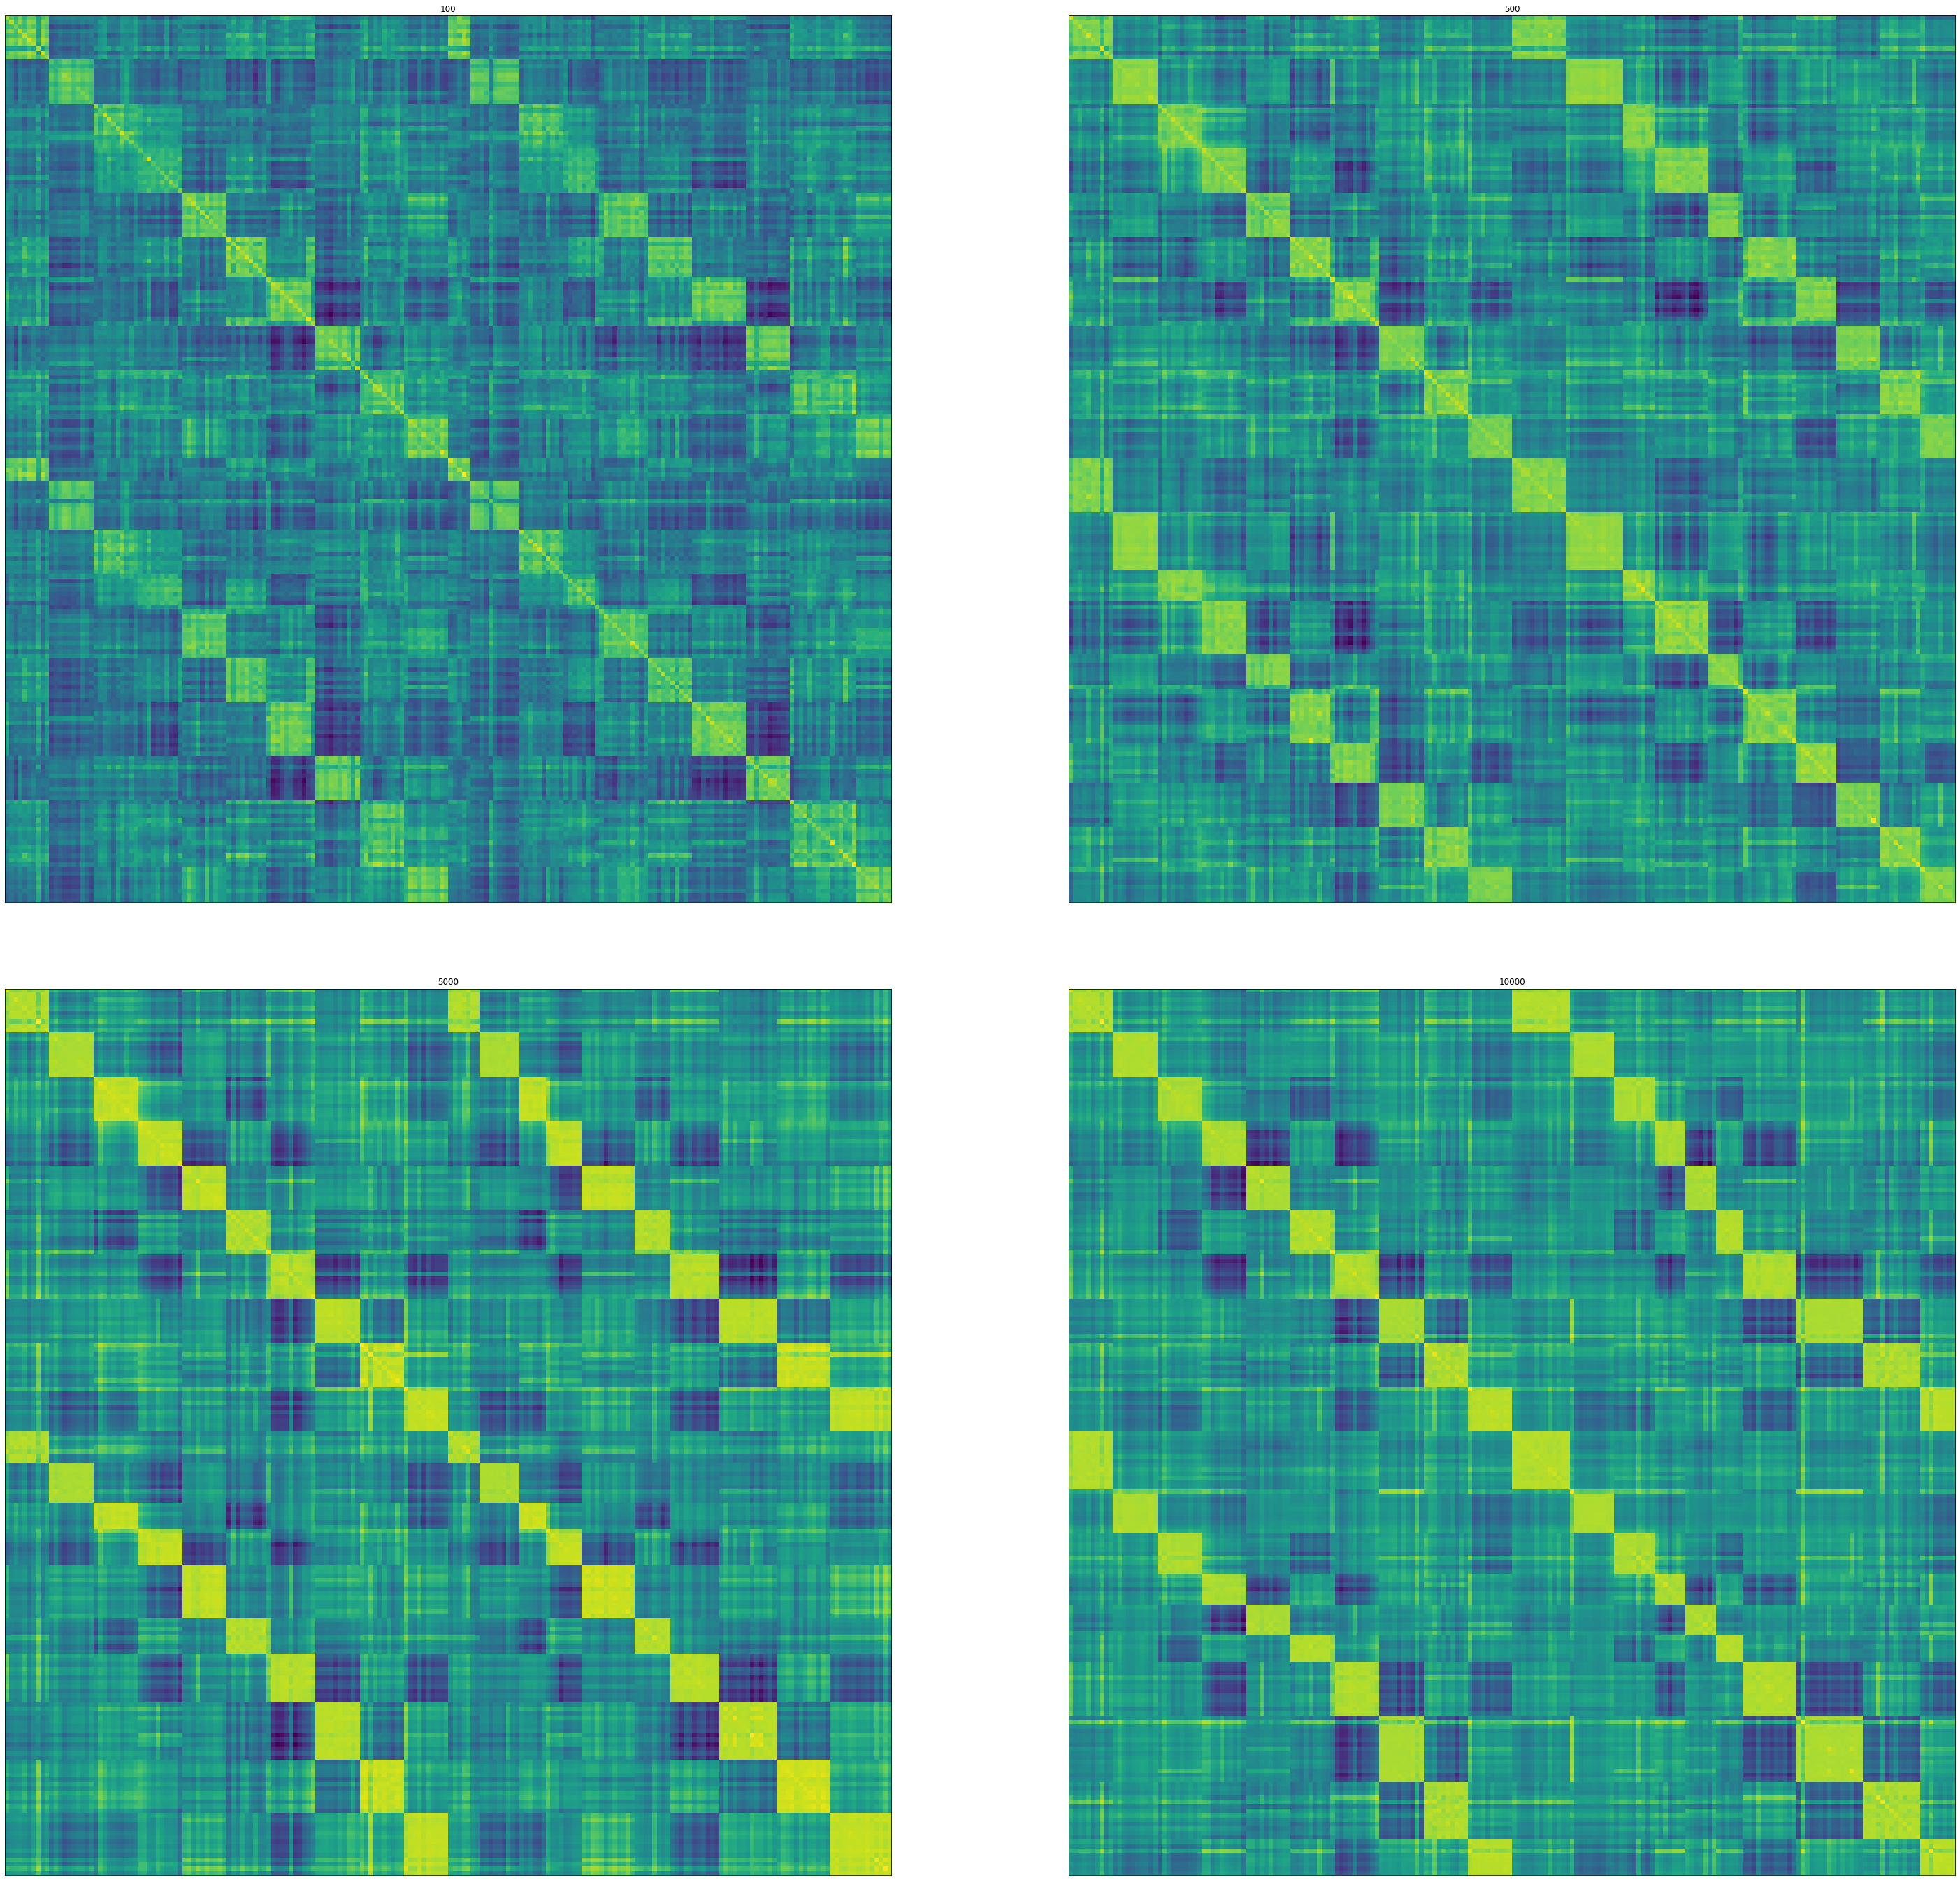

In [19]:
vis.imshow(similarities, figsize=(50,50), num_row=2,hspace=0.05, labels=labels, imgwidth=200)

In [20]:
from ipywidgets import FloatSlider
from IPython.html.widgets import *

stacked100 = get_embedded(100, log_dir)
stacked2000 = get_embedded(10000, log_dir)

interact(
    lambda sigma: vis.imshow(
        [
            get_similarity(stacked100, Distance.get_gaussian_k(sigma)),
            get_similarity(stacked2000, Distance.get_gaussian_k(sigma)),
        ], figsize=(50,50), hspace=0.05, labels=[100,10000], imgwidth=200
    ),
    sigma = FloatSlider(
        value=1,
        min=0.5,
        max=10.0,
        step=0.1,
        description='Effect of Gaussian Kernel',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
)

INFO:tensorflow:Restoring parameters from logs/visit-05-100


/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


INFO:tensorflow:Restoring parameters from logs/visit-05-10000


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Effect of Gaussian Kernel',…

<function __main__.<lambda>(sigma)>